In [1]:
from pymongo import MongoClient
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import numpy as np
import math
import gc

%matplotlib inline  

client = MongoClient(port=27123)
db = client.frevue_data
coll = db.Trips
#cursor = coll.find({"Owner": "United Kingdom, London, UPS"})

# import data and extract list of data owner and the count of data entries for each data owner 

In [2]:
# this section check the number of partners in the database
# choose a partner and check the number of unique vehicles
# then for each vehicle check the number of available days

cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfRecords": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
print vehlist

    NumberOfRecords                                          _id
0               413                Netherlands, Rotterdam, EMOSS
1             12675      Netherlands, Amsterdam & Rotterdam, TNT
2               161              United Kingdom, London, Clipper
3              1096                        Portugal, Lisbon, CTT
4               541             Netherlands, Amsterdam, Heineken
5              1143  Spain, Madrid, Calidad Pascual & SEUR & TNT
6              1652                  Netherlands, Rotterdam, UPS
7              2987  Netherlands, Amsterdam & Rotterdam, TNT RAW
8               319             Netherlands, Rotterdam, Heineken
9              1589                       Portugal, Lisbon, EMEL
10            15800                  United Kingdom, London, UPS
11               68                          Italy, Milano, AMAT


# choose a data owner

In [3]:
curpartner = vehlist.iloc[4,1]   #current partner can set up a loop  ********************
print "current data owner selected is " + curpartner

current data owner selected is Netherlands, Amsterdam, Heineken


# now extract the number of vehicles (vehicleid) available for the chosen partner and the number of days which data is available for each vehicle

In [4]:
# check valid recordings (distance bigger than 0)
cursor2 = coll.find(
        {"$and": [
                 {"Owner": curpartner},
                 {"Distance": {"$gt": 0}}
                ]
        })
PD_Fields = ['TripId', 'Owner', 'VehicleId', 'Frequency', 'Aggregation', 'Distance', 'StateOfChargeStart', 'StateOfChargeEnd', 
            'StateOfChargeMax', 'StateOfChargeMin', 'StateOfChargeUp', 'StateOfChargeDown', 'StartTime', 'EndTime', 'Duration',
            'Extras']
PartnerData = pd.DataFrame(list(cursor2), columns=PD_Fields)
PartnerData['sday'] = [x.date() for x in PartnerData['StartTime']]
PartnerData['eday'] = [x.date() for x in PartnerData['EndTime']]
# printing
Veh_num = len(PartnerData['VehicleId'].unique()) #count the number of vehilces
print "Total number of vehicle is " + str(Veh_num) + " from " + curpartner    #number of vehicles

check = sum(PartnerData['sday'] <> PartnerData['eday'])
print "the number of a vehicle with different strip start and end dates is " + str(check)

# check how many days worth of data is availale for each vehicle
# PartnerData['newVID'] = PartnerData['VehicleId'].str[:6] ### ONLY FOR UPS (their data seems to have duplicate vehilces)
# Veh_num2 = len(PartnerData['newVID'].unique())
# print Veh_num2
#veh_days = pd.DataFrame(PartnerData.groupby('newVID').size().rename('numofdays'))
veh_days = pd.DataFrame(PartnerData.groupby('VehicleId').size().rename('numofdays'))
veh_days = veh_days.reset_index(range(veh_days.count()))
veh_days['VID'] = veh_days.index + 1
print "Summary of data availability for each vehicle"
print veh_days


# merge to get unique vehilce ID for each vehicle (for plotting purpose)
#PartnerData = pd.merge(PartnerData, veh_days, left_on = "newVID", right_on = "newVID")
PartnerData = pd.merge(PartnerData, veh_days, left_on = "VehicleId", right_on = "VehicleId")

#tripid should note be used anymore
# PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])

Total number of vehicle is 6 from Netherlands, Amsterdam, Heineken
the number of a vehicle with different strip start and end dates is 4
Summary of data availability for each vehicle
   VehicleId  numofdays  VID
0  GINAF 001        196    1
1  GINAF 002         59    2
2  GINAF 004         95    3
3  GINAF 005         77    4
4  GINAF 006         60    5
5  GINAF 007         41    6


# optional - if the number of vehicle with different trip start and end dates is not zero

In [5]:
PartnerData[PartnerData['sday'] <> PartnerData['eday']]

,TripId,Owner,VehicleId,Frequency,Aggregation,Distance,StateOfChargeStart,StateOfChargeEnd,StateOfChargeMax,StateOfChargeMin,StateOfChargeUp,StateOfChargeDown,StartTime,EndTime,Duration,Extras,sday,eday,numofdays,VID
87,2015-09-10,"Netherlands, Amsterdam, Heineken",GINAF 001,1,1,8755.0,100.0,62.0,100.0,62.0,24.0,-62.0,2015-09-09 22:00:05,2015-09-10 14:34:55,59690,"{u'DistanceGps': {u'_v': 48279.7030597, u'_t':...",2015-09-09,2015-09-10,196,1
173,2016-01-08,"Netherlands, Amsterdam, Heineken",GINAF 001,1,1,54810.0,84.0,56.0,100.0,56.0,34.0,-62.0,2016-01-07 23:00:05,2016-01-08 16:02:48,61363,"{u'DistanceGps': {u'_v': 49869.0500523, u'_t':...",2016-01-07,2016-01-08,196,1
222,2016-03-26,"Netherlands, Amsterdam, Heineken",GINAF 001,1,1,55240.0,100.0,62.0,100.0,62.0,12.0,-50.0,2016-03-25 23:00:00,2016-03-26 14:14:31,54871,"{u'DistanceGps': {u'_v': 56187.6154813, u'_t':...",2016-03-25,2016-03-26,196,1
246,2016-05-23,"Netherlands, Amsterdam, Heineken",GINAF 001,1,1,46125.0,100.0,63.0,100.0,62.0,25.0,-62.0,2016-05-22 22:00:03,2016-05-23 14:04:36,57873,"{u'DistanceGps': {u'_v': 46376.4553071, u'_t':...",2016-05-22,2016-05-23,196,1


# NOTE: Plotting of data availability is based on the "endtime" record

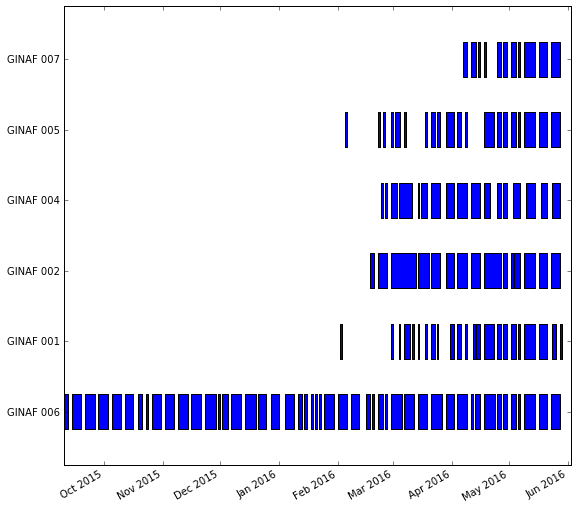

In [6]:
# plotting data availability
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)

for i in PartnerData['VehicleId'].unique():
    datelist = []
    selVehData = PartnerData[PartnerData['VehicleId']==i]
    curID = selVehData['VID'].iloc[0]
    sdate = selVehData['eday'].min()
    edate = selVehData['eday'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['eday'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['eday'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
ax1.xaxis_date()
ax1.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
ax1.set_ylim(0.5, len(PartnerData['VehicleId'].unique())+1)
ax1.yaxis.set_ticks(np.arange(1.25, len(PartnerData['VehicleId'].unique())+1))
ax1.set_yticklabels(PartnerData['VehicleId'].unique())
fig.autofmt_xdate()

# plotting of total distance per day

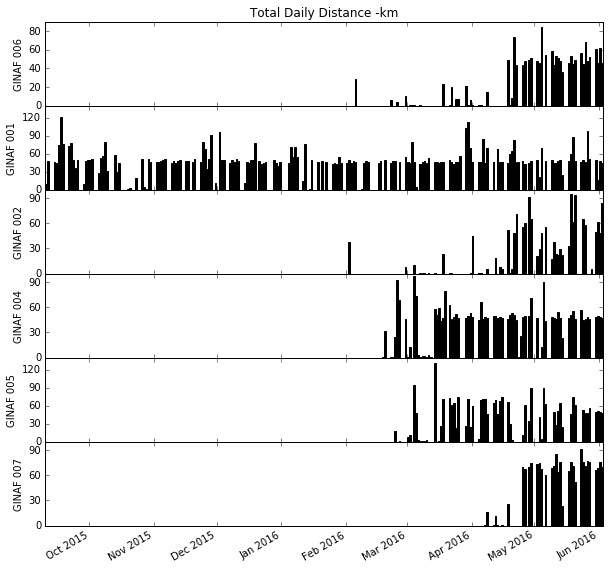

In [7]:
fig2 = pl.figure(figsize=(10, 10))
fig2.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    vehid = PartnerData['VehicleId'].unique()[i]
    selVehData2 = PartnerData[PartnerData['VehicleId']==vehid]

    sdate2 = selVehData2['eday'].min()
    edate2 = selVehData2['eday'].max()

    delta2 = edate2-sdate2
    
    v = v+1
    ax2 = fig2.add_subplot(number_of_subplots,1,v)
    ax2.bar(mpl.dates.date2num(selVehData2['eday']), selVehData2['Distance']/1000, color='black')

    ax2.xaxis_date()
    ax2.set_xlim(PartnerData['eday'].min(), PartnerData['eday'].max())
    ax2.set_ylabel(vehid)
    if i == 0:
        ax2.set_title("Total Daily Distance -km")
    maxdis = max(selVehData2['Distance']/1000)
    ax2.set_yticks(range(0,int(maxdis*1.1), int(math.ceil((maxdis*1.1/5)/10)*10)))
    
fig2.autofmt_xdate()


# some statistics of daily distance for each of the vehicle

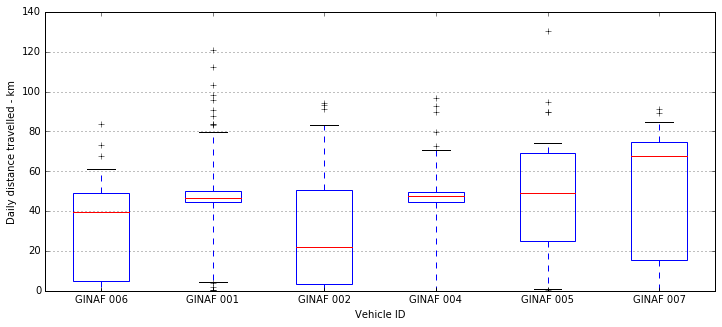

In [8]:
# box plot for distance statistics

fig3 = plt.figure(figsize=(12, 5))
ax3 = fig3.add_subplot(1,1,1)
# # Random test data
# np.random.seed(123)
# all_data = [np.random.normal(0, std, 100) for std in range(1, 4)]

lsdata = []
lsveh = []
boxplotdata = []
for i in PartnerData['VehicleId'].unique():
    lsveh.append(i)
    currdata = np.array(PartnerData[PartnerData['VehicleId']==i]['Distance']/1000)
    boxplotdata.append(currdata)

boxplotdata = np.array(boxplotdata)
# boxplotdata['VehicleId'] = PartnerData['VehicleId']

# rectangular box plot
ax3.boxplot(boxplotdata,
            vert=True,   # vertical box aligmnent
            patch_artist=True, 
            whis=[5, 95])


# adding horizontal grid lines
ax3.yaxis.grid(True)
ax3.set_xticks([y+1 for y in range(len(PartnerData['VehicleId'].unique()))], )
ax3.set_xlabel('Vehicle ID')
ax3.set_ylabel('Daily distance travelled - km')

# add x-tick labels
plt.setp(ax3, xticks=[y+1 for y in range(len(PartnerData['VehicleId'].unique()))],
         xticklabels=lsveh)

# plt.show()

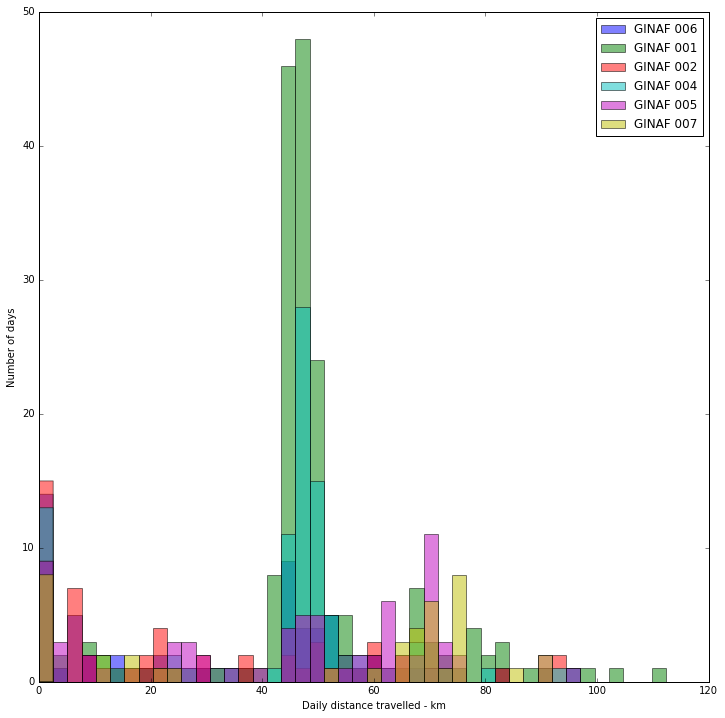

In [9]:
# histogram 

fig4 = plt.figure(figsize=(12, 12))
ax4 = fig4.add_subplot(1,1,1)

bins = np.linspace(0,120,48)

# rectangular box plot
for i in range(len(boxplotdata)):
    ax4.hist(boxplotdata[i], bins, alpha=0.5, label = lsveh[i])
ax4.legend(loc='upper right')
    
# adding horizontal grid lines
# ax3.yaxis.grid(True)
# ax3.set_xticks([y+1 for y in range(len(PartnerData['VehicleId'].unique()))], )
ax4.set_ylabel('Number of days')
ax4.set_xlabel('Daily distance travelled - km')


# now look at telematics data (seconds data)

In [25]:
#import detailed data and create a dataframe
# cursor2 = coll.find(
#         {"$and": [
#                  {"Owner": curpartner},
#                  {"Distance": {"$gt": 0}}
#                 ]
#         })

cursor2 = coll.find({"Owner": curpartner})

DetailedData = []

for record in cursor2:
    veh_id = record['VehicleId']
    for datapoint in record['DataPoints']:
        eachdatapoint = {
            "timestamp": datapoint.get('ts'),
            "lat": datapoint.get('lat'),
            "lon": datapoint.get('lon'),
            "alt": datapoint.get('alt'),
            "speed": datapoint.get('s'),
            "soc": datapoint.get('soc'),
            "range": datapoint.get('r'),
            "batterytemp": datapoint.get('tb'),
            "cabtemp": datapoint.get('ti'),
            "outsidetemp": datapoint.get('to'),
            "throttle": datapoint.get('thr'),
            "ignition": datapoint.get('i'),
            'VehID': veh_id
        }
        DetailedData.append(eachdatapoint)
gc.collect()

DetailedData = pd.DataFrame(DetailedData).sort_values(by = 'timestamp')
DetailedData = DetailedData.reset_index(drop=True)

# plotting of the state of charge status over the periods

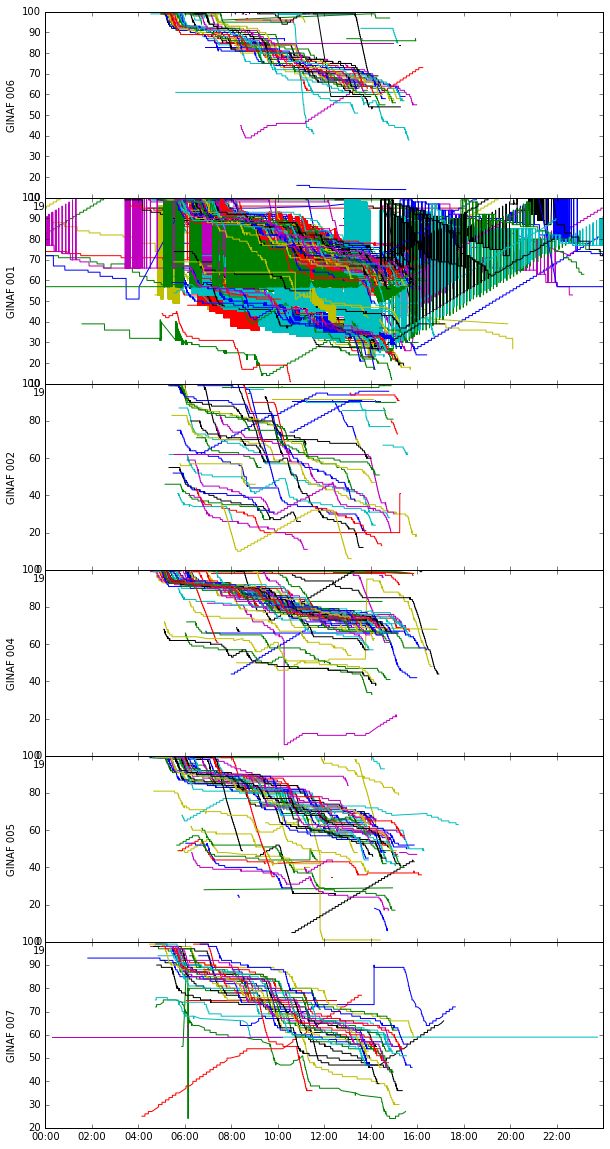

In [65]:

DetailedData['time'] = [x.time() for x in DetailedData['timestamp']]
DetailedData['date'] = [x.date() for x in DetailedData['timestamp']]

fig5 = pl.figure(figsize=(10, 20))
fig5.subplots_adjust(hspace=0.0)
# pl.subplots_adjust(hspace=0.1)
number_of_subplots=len(PartnerData['VehicleId'].unique())

for i,v in enumerate(xrange(number_of_subplots)):
    vehid5 = PartnerData['VehicleId'].unique()[i]
    selVehData5 = DetailedData[DetailedData['VehID']==vehid5]
#     datelist = [dt.datetime.strptime(str(x), "%H:%M:%S") for x in selDate['time']]
    datemin = dt.datetime.strptime("1900-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
    datemax = dt.datetime.strptime("1900-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
    v = v+1
    ax5 = fig5.add_subplot(number_of_subplots,1,v)
    for j in selVehData5['date'].unique():
        selDate = selVehData5[selVehData5['date'] ==j]
        ax5.plot(mpl.dates.date2num([dt.datetime.strptime(str(x), "%H:%M:%S") for x in selDate['time']]), 
                 selDate['soc'])
    ax5.set_ylabel(vehid5)
    ax5.set_ylim(0, 100)
    ax5.set_yticks(range(0,100,20))
    ax5.set_xlim(datemin,datemax)
    ax5.set_xticks(np.arange(datemin, datemax, (datemax - datemin)/12))

xfmt = mpl.dates.DateFormatter('%H:%M')
ax5.xaxis.set_major_formatter(xfmt)
    
# fig5.autofmt_xdate()


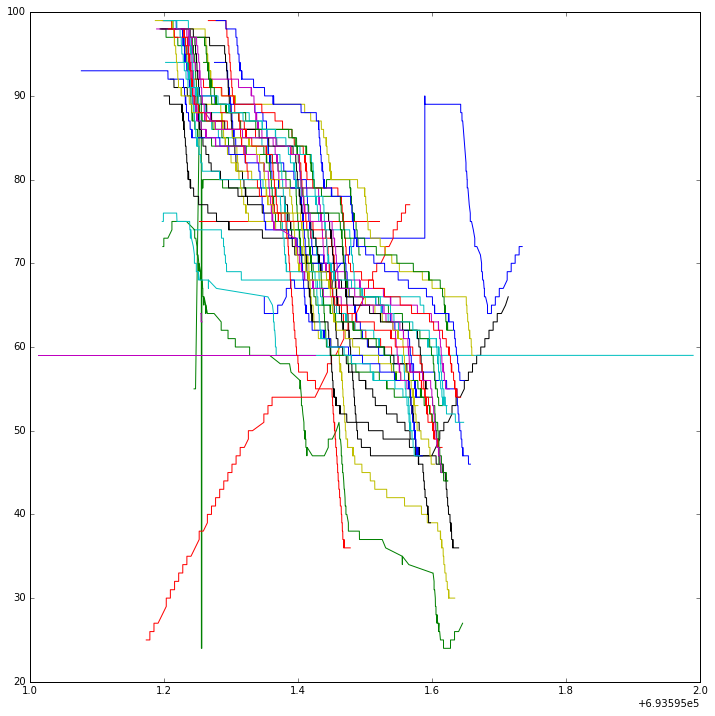

In [57]:
fig5 = plt.figure(figsize=(12, 12))
ax5 = fig5.add_subplot(1,1,1)
for j in selVehData5['date'].unique():
    selDate = selVehData5[selVehData5['date'] ==j]
    ax5.plot(mpl.dates.date2num([dt.datetime.strptime(str(x), "%H:%M:%S") for x in selDate['time']]), 
             selDate['soc'])


In [64]:
datelist

[datetime.datetime(1900, 1, 1, 5, 33, 44),
 datetime.datetime(1900, 1, 1, 5, 33, 45),
 datetime.datetime(1900, 1, 1, 5, 33, 46),
 datetime.datetime(1900, 1, 1, 5, 33, 47),
 datetime.datetime(1900, 1, 1, 5, 33, 48),
 datetime.datetime(1900, 1, 1, 5, 33, 49),
 datetime.datetime(1900, 1, 1, 5, 33, 50),
 datetime.datetime(1900, 1, 1, 5, 33, 51),
 datetime.datetime(1900, 1, 1, 5, 33, 52),
 datetime.datetime(1900, 1, 1, 5, 33, 53),
 datetime.datetime(1900, 1, 1, 5, 33, 54),
 datetime.datetime(1900, 1, 1, 5, 33, 55),
 datetime.datetime(1900, 1, 1, 5, 33, 56),
 datetime.datetime(1900, 1, 1, 5, 33, 57),
 datetime.datetime(1900, 1, 1, 5, 33, 59),
 datetime.datetime(1900, 1, 1, 5, 34, 1),
 datetime.datetime(1900, 1, 1, 5, 34, 2),
 datetime.datetime(1900, 1, 1, 5, 34, 3),
 datetime.datetime(1900, 1, 1, 5, 34, 4),
 datetime.datetime(1900, 1, 1, 5, 34, 5),
 datetime.datetime(1900, 1, 1, 5, 34, 6),
 datetime.datetime(1900, 1, 1, 5, 34, 7),
 datetime.datetime(1900, 1, 1, 5, 34, 8),
 datetime.datetime(

In [55]:
selVehData5['date'].unique()

array([datetime.date(2016, 4, 7), datetime.date(2016, 4, 8),
       datetime.date(2016, 4, 11), datetime.date(2016, 4, 12),
       datetime.date(2016, 4, 13), datetime.date(2016, 4, 15),
       datetime.date(2016, 4, 18), datetime.date(2016, 4, 19),
       datetime.date(2016, 4, 20), datetime.date(2016, 4, 21),
       datetime.date(2016, 4, 22), datetime.date(2016, 4, 23),
       datetime.date(2016, 4, 25), datetime.date(2016, 4, 26),
       datetime.date(2016, 4, 28), datetime.date(2016, 4, 29),
       datetime.date(2016, 5, 2), datetime.date(2016, 5, 3),
       datetime.date(2016, 5, 4), datetime.date(2016, 5, 6),
       datetime.date(2016, 5, 9), datetime.date(2016, 5, 10),
       datetime.date(2016, 5, 11), datetime.date(2016, 5, 12),
       datetime.date(2016, 5, 13), datetime.date(2016, 5, 14),
       datetime.date(2016, 5, 17), datetime.date(2016, 5, 18),
       datetime.date(2016, 5, 19), datetime.date(2016, 5, 20),
       datetime.date(2016, 5, 23), datetime.date(2016, 5, 24),

In [ ]:
currdata

# need to check whether there are multiple trips from a same vehicle in a single day

In [ ]:
sum(PartnerData['sday'] <> PartnerData['eday'])

In [ ]:
PartnerData.head(5)

In [ ]:
# plotting data availability
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)

for i in PartnerData['VehicleId'].unique():
    datelist = []
    selVehData = PartnerData[PartnerData['VehicleId']==i]
    curID = selVehData['VID'].iloc[0]
    sdate = selVehData['TripId'].min()
    edate = selVehData['TripId'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['TripId'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['TripId'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
ax1.xaxis_date()
ax1.set_xlim(PartnerData['TripId'].min(), PartnerData['TripId'].max())

In [ ]:
PartnerData.head(5)

In [ ]:
mpl.dates.date2num(dt.datetime.now())

In [ ]:
curdate = sdate + dt.timedelta(days=1)
print curdate
any(selVehData['TripId'] == curdate)

In [ ]:
#import datetime
#tt = datetime.datetime.strptime(PartnerData['TripId'], "%Y-%m-%d")
PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])
#tt.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
#for i in range(0, PartnerData['TripId'].count()):
ax1.broken_barh(PartnerData['TripId'], PartnerData['VID'])

In [ ]:
cursor = coll.find(
        {"$and": [
                 {"Owner": "United Kingdom, London, UPS"},
                 {"Distance": {"$gt": 0}}
                ]
        })
UPSLondon = pd.DataFrame(list(cursor))

In [ ]:
cursor2 = coll.aggregate([
    {"$match": {"$and": [
                        {"Owner": vehlist.iloc[0,1]}, 
                        {"Distance": {"$gt": 0}}
                ]}
    },
    {"$group": {"_id": "$VehicleId", "AverageDistance": {"$avg": "$Distance"}}}
])

In [ ]:
print PartnerData.head(n=10)
PartnerData.iloc[0,5]
len(PartnerData['VehicleId'].unique())

In [ ]:
cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfTrips": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
curpartner = vehlist.iloc[7,1]   #current partner can set up a loop  ********************
print curpartner